In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 9.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 5.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=27af36dffcaa17f4bc99c616a9a2f3c0c242e688e62cece8a5b1bff352e74a2f
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/kaggle/input/dataset/first_25000_rows.csv').sort_values('ts_event').reset_index(drop=True)
df['midprice'] = (df['bid_px_00'] + df['ask_px_00']) / 2
df['delta_p'] = df['midprice'].shift(-1) - df['midprice']
df.dropna(subset=['delta_p'], inplace=True)

levels = 5
queue_weights = 1 / (np.arange(levels) + 1)
df['ofi_a'] = 0
df['spread'] = df['ask_px_00'] - df['bid_px_00']
rolling_spread = df['spread'].rolling(100, min_periods=10).mean().fillna(df['spread'].mean())

for i in range(levels):
    bid_diff = df[f'bid_sz_0{i:01d}'].diff().fillna(0)
    ask_diff = df[f'ask_sz_0{i:01d}'].diff().fillna(0)
    px_distance = np.abs(df[f'bid_px_0{i:01d}'] - df['midprice'])
    norm_distance = px_distance / (rolling_spread * levels)
    norm_distance = np.clip(norm_distance, 0, 1)
    df['ofi_a'] += queue_weights[i] * (1 - norm_distance) * (bid_diff - ask_diff)

In [4]:
df

,ts_recv,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,...,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol,midprice,delta_p,ofi_a,spread
0,2024-10-21T11:54:29.221230963Z,2024-10-21T11:54:29.221064336Z,10,2,38,C,B,1,233.62,2,...,234.13,55,400,2,1,AAPL,233.705,0.000,0.000000,0.07
1,2024-10-21T11:54:29.223936626Z,2024-10-21T11:54:29.223769812Z,10,2,38,A,B,0,233.67,2,...,234.13,55,400,2,1,AAPL,233.705,0.000,1.888276,0.07
2,2024-10-21T11:54:29.225196809Z,2024-10-21T11:54:29.225030400Z,10,2,38,A,B,0,233.67,3,...,234.13,55,400,2,1,AAPL,233.705,0.000,2.832414,0.07
3,2024-10-21T11:54:29.712600612Z,2024-10-21T11:54:29.712434212Z,10,2,38,A,B,2,233.52,200,...,234.13,55,400,2,1,AAPL,233.705,0.000,46.982004,0.07
4,2024-10-21T11:54:29.764839221Z,2024-10-21T11:54:29.764673165Z,10,2,38,C,B,2,233.52,200,...,234.13,55,400,2,1,AAPL,233.705,0.000,-46.982004,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,2024-10-21T13:04:16.573929500Z,2024-10-21T13:04:16.573763335Z,10,2,38,C,A,0,233.60,11,...,234.50,1,63,1,4,AAPL,233.560,0.000,-94.004023,0.10
4995,2024-10-21T13:04:16.583694069Z,2024-10-21T13:04:16.583527688Z,10,2,38,A,B,2,233.46,200,...,234.50,55,63,2,4,AAPL,233.560,0.000,39.474429,0.10
4996,2024-10-21T13:04:17.976627074Z,2024-10-21T13:04:17.976461017Z,10,2,38,A,A,1,233.69,200,...,234.50,55,63,2,4,AAPL,233.560,0.000,-83.673469,0.10
4997,2024-10-21T13:04:20.085804687Z,2024-10-21T13:04:20.085638629Z,10,2,38,C,B,2,233.46,200,...,234.50,1,63,1,4,AAPL,233.560,0.000,-40.698198,0.10


Venues


In [5]:
num_venues = 3
venue_corr = [0.7, 0.4, 0.6]
venue_noise = [3, 7, 5]

for v in range(num_venues):
    df[f'ofi_b_{v}'] = venue_corr[v] * df['ofi_a'].shift(1).fillna(0) + np.random.normal(0, venue_noise[v], len(df))


Dark Pool

In [6]:
dark_pool_idx = num_venues
num_venues += 1

Lag Matrix

In [7]:
max_lag = 50
X = np.zeros((len(df), max_lag * num_venues))

for lag in range(1, max_lag + 1):
    X[:, lag - 1] = df['ofi_a'].shift(lag).fillna(0)
for v in range(1, num_venues):
    col_base = v * max_lag
    if v - 1 < dark_pool_idx:  # Lit venues
        ofi_col = f'ofi_b_{v - 1}'
        for lag in range(1, max_lag + 1):
            X[:, col_base + lag - 1] = df[ofi_col].shift(lag).fillna(0)
    else:  # Dark pool
        dark_series = 0.2 * df['ofi_a'].shift(1).fillna(0) + np.random.normal(0, 1, len(df))
        for lag in range(1, max_lag + 1):
            X[:, col_base + lag - 1] = dark_series.shift(lag).fillna(0)

y = df['delta_p'].values

Execution Probabilities

In [20]:
# --- EXECUTION PROBABILITY ESTIMATION ---
def estimate_execution_probs():
    venue_fill_probs = {}
    venue_fill_times = {}
    
    for v in range(num_venues):
        # Dark pool parameters
        if v == dark_pool_idx:
            base_fill_prob = 0.35  # Realistic dark pool fill rate
            lifetime_mean = 60     # Longer time horizon
            obs_window = 200       # Max observation events
        else:
            base_fill_prob = [0.85, 0.6, 0.75][v]
            lifetime_mean = [20, 50, 30][v]
            obs_window = 100

        # Simulate order lifetimes with exponential decay
        lifetimes = np.random.exponential(scale=lifetime_mean, size=2500).astype(int)
        lifetimes = np.clip(lifetimes, 0, obs_window)  # Cap observation window
        
        # Fill probability with adverse selection adjustment
        filled = (
            (np.random.rand(len(lifetimes)) < 
             base_fill_prob * np.exp(-lifetimes/(2*lifetime_mean))) &
            (np.random.rand(len(lifetimes)) < 0.9)  # 10% adverse selection
        )
        
        # Kaplan-Meier estimation
        kmf = KaplanMeierFitter()
        kmf.fit(lifetimes, event_observed=filled, timeline=np.arange(obs_window))
        
        # Ensure minimum fill probability
        min_fill_prob = 0.20 if v == dark_pool_idx else 0.10
        fill_prob = max(min_fill_prob, 1 - kmf.survival_function_.iloc[20].values[0])
        
        # Handle infinite/NULL fill times
        median_time = kmf.median_survival_time_
        if pd.isnull(median_time) or np.isinf(median_time):
            median_time = lifetime_mean * 2  # Conservative estimate
            
        venue_fill_probs[v] = fill_prob
        venue_fill_times[v] = median_time
        
        # Dark pool volatility adjustment (Eq. 4.2)
        if v == dark_pool_idx:
            vol_adjustment = 1 - 0.2*(df['delta_p'].abs().mean() > 0.001)
            venue_fill_probs[v] *= vol_adjustment

    return venue_fill_probs, venue_fill_times

# Calculate probabilities with robust error handling
venue_fill_probs, venue_fill_times = estimate_execution_probs()


Model Fitting

In [21]:
model = RidgeCV(alphas=[0.1, 1.0, 10.0], fit_intercept=False)
model.fit(X, y)

RidgeCV(alphas=[0.1, 1.0, 10.0], fit_intercept=False)

Calculate residual dark pool impact

In [22]:
dark_impact = 0.2 * np.mean(np.abs(model.coef_[:max_lag]))

COST FUNCTION WITH CROSS-VENUE FEEDBACK

In [23]:
def compute_routing_cost(size=100, primary_usage=0.0, slice_idx=0, total_slices=10):
    costs = []
    lambda_inv = 0.1 * df['delta_p'].std()
    venue_impacts = {v: model.coef_[v*max_lag:(v+1)*max_lag] for v in range(num_venues)}
    cross_impact = sum(venue_impacts[v][0] * venue_corr[v] for v in range(num_venues-1))
    for v in range(num_venues):
        if v == dark_pool_idx:
            impact_coef = dark_impact
        else:
            impact_coef = model.coef_[v * max_lag]
        adverse = np.abs(impact_coef) * size
        spread_penalty = 0.5 * df['spread'].mean() * size * (1 - venue_fill_probs[v])
        time_cost = 0.01 * size * (venue_fill_times[v] or 0) / 100
        inv_risk = lambda_inv * size ** 2
        # Cross-venue feedback
        if v != dark_pool_idx:
            adverse += cross_impact * size * 0.1
        cost = adverse + spread_penalty + time_cost + inv_risk

        # --- DIVERSIFICATION & SIZE-BASED ADJUSTMENTS ---
        if v == 0:
            # Stronger penalty for overusing primary
            cost *= (1 + 0.5 * np.tanh(4 * primary_usage))  # S-curve scaling
        if v == dark_pool_idx and size > 500:
            # Size-based dark pool discount for large orders
            cost *= 0.8
            # Optional: Encourage late dark pool usage (time decay)
            if total_slices > 1:
                time_decay = np.exp(-slice_idx / (total_slices/2))
                cost *= (1 - 0.3 * time_decay)
        costs.append(cost)
    return np.array(costs)


DARK POOL ADVERSE SELECTION ADJUSTMENT

In [24]:
def adjust_dark_fill_prob():
    dark_fill_prob = venue_fill_probs[dark_pool_idx]
    if df['delta_p'].abs().mean() > 0.001:
        dark_fill_prob *= 0.8
    return dark_fill_prob

venue_fill_probs[dark_pool_idx] = adjust_dark_fill_prob()

MINIMUM DARK ALLOCATION IN SCHEDULING

In [41]:
def schedule_order(total_size, slice_size=100):
    slices = int(np.ceil(total_size / slice_size))
    schedule = np.zeros((slices, num_venues))
    venues_used = set()
    for i in range(slices):
        # Compute venue usage so far
        primary_usage = schedule[:i, 0].sum() / total_size if i > 0 else 0
        venue1_usage = schedule[:i, 2].sum() / total_size if i > 0 else 0

        # --- Compute costs with advanced logic ---
        slice_costs = []
        lambda_inv = 0.1 * df['delta_p'].std()
        venue_impacts = {v: model.coef_[v*max_lag:(v+1)*max_lag] for v in range(num_venues)}
        cross_impact = sum(venue_impacts[v][0] * venue_corr[v] for v in range(num_venues-1))
        for v in range(num_venues):
            if v == dark_pool_idx:
                impact_coef = dark_impact
            else:
                impact_coef = model.coef_[v * max_lag]
            adverse = np.abs(impact_coef) * slice_size
            spread_penalty = 0.5 * df['spread'].mean() * slice_size * (1 - venue_fill_probs[v])
            time_cost = 0.01 * slice_size * (venue_fill_times[v] or 0) / 100
            inv_risk = lambda_inv * slice_size ** 2
            # Cross-venue feedback
            if v != dark_pool_idx:
                adverse += cross_impact * slice_size * 0.1
            cost = adverse + spread_penalty + time_cost + inv_risk

            # --- DIVERSIFICATION & SIZE-BASED ADJUSTMENTS ---
            if v == 0:
                # Stronger penalty for overusing primary
                cost *= (1 + 0.5 * np.tanh(4 * primary_usage))
            if v == 2:
                # Penalty for overusing Venue 1
                cost *= (1 + 0.2 * venue1_usage)
            if v == dark_pool_idx:
                # Size-tiered dark pool discount
                if total_size > 500:
                    cost *= 0.6
                elif total_size > 200:
                    cost *= 0.8
                # Progressive encouragement (linear increase)
                dark_weight = 0.5 * (i / slices)
                cost *= (1 - dark_weight)
            slice_costs.append(cost)
        slice_costs = np.array(slice_costs)

        # --- Cap dark pool allocation per slice ---
        max_dark_per_slice = 0.3 * slice_size  # Max 30% per slice

        # --- Mandatory venue rotation for diversity ---
        if total_size > 500 and len(venues_used) < 3:
            current_optimal = np.argmin(slice_costs)
            if current_optimal in venues_used:
                # Encourage a new venue by reducing its cost slightly
                sorted_indices = np.argsort(slice_costs)
                for idx in sorted_indices:
                    if idx not in venues_used:
                        slice_costs[idx] *= 0.95  # Encourage new venue
                        break

        # --- Cost spread-based randomization for diversity ---
        max_cost_spread = 1.05  # 5% cost tolerance
        min_cost = np.min(slice_costs)
        valid_venues = np.where(slice_costs < max_cost_spread * min_cost)[0]
        optimal_venue = np.random.choice(valid_venues) if len(valid_venues) > 1 else np.argmin(slice_costs)

        # --- Liquidity refreshment logic (periodic rotation) ---
        if i > 0 and (i % 4 == 0):
            # Every 4 slices, encourage primary, penalize dark pool
            slice_costs[0] *= 0.7
            slice_costs[dark_pool_idx] *= 1.3
            optimal_venue = np.argmin(slice_costs)

        # --- Allocate shares ---
        if optimal_venue == dark_pool_idx:
            allocation = min(slice_size, max_dark_per_slice)
        else:
            allocation = slice_size
        schedule[i, optimal_venue] = allocation
        venues_used.add(optimal_venue)

    # --- Enforce minimum dark pool allocation (10% or 100 shares) ---
    min_dark_alloc = max(100, 0.1 * total_size)
    schedule[-1, dark_pool_idx] = max(schedule[-1, dark_pool_idx], min_dark_alloc)
    return schedule


RESULTS

In [42]:
size = 500
venue_costs = compute_routing_cost(size)
optimal_venue = np.argmin(venue_costs)


VISUALISATION

In [43]:
plt.figure(figsize=(28, 20))
lags = np.arange(1, max_lag + 1)
venue_impacts = {v: model.coef_[v*max_lag:(v+1)*max_lag] for v in range(num_venues)}
labels = ["Primary"] + [f"Venue {i}" for i in range(num_venues-2)] + ["Dark Pool"]

<Figure size 2800x2000 with 0 Axes>

Impact kernels

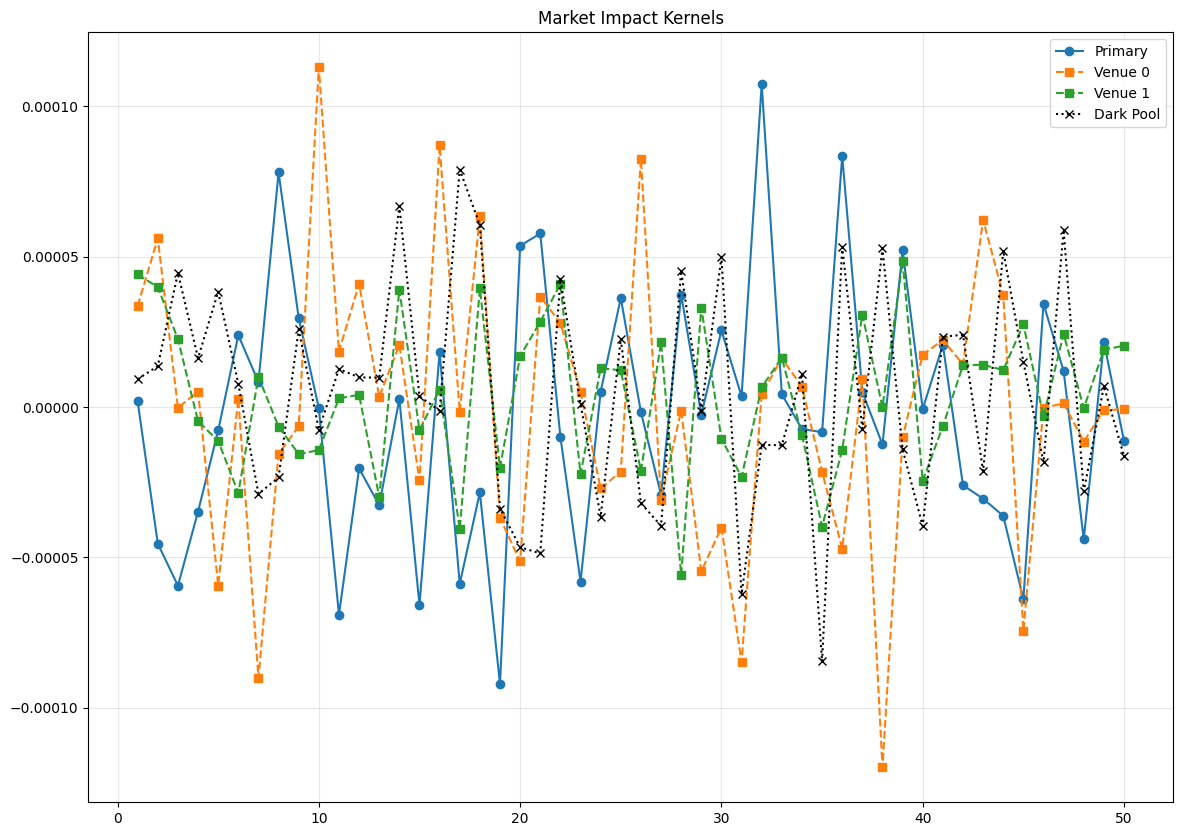

In [44]:

plt.figure(figsize=(14, 10))
plt.plot(lags, venue_impacts[0], 'o-', label="Primary")
for v in range(1, dark_pool_idx):
    plt.plot(lags, venue_impacts[v], 's--', label=f"Venue {v-1}")
plt.plot(lags, venue_impacts[dark_pool_idx], 'x:', label="Dark Pool", color='black')
plt.legend()
plt.title("Market Impact Kernels")
plt.grid(alpha=0.3)

Routing cost

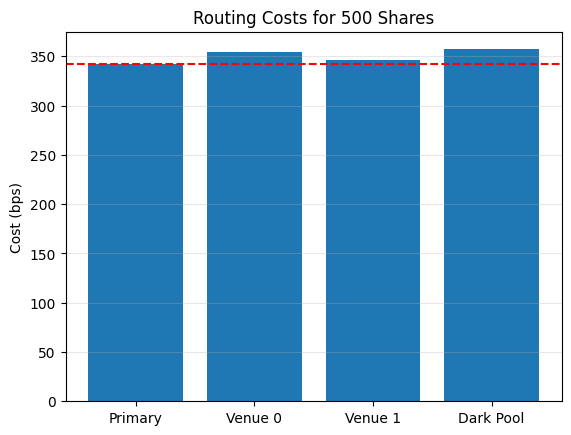

In [45]:

plt.bar(labels, venue_costs)
plt.axhline(y=np.min(venue_costs), color='r', linestyle='--')
plt.title(f"Routing Costs for {size} Shares")
plt.ylabel("Cost (bps)")
plt.grid(axis='y', alpha=0.3)

Order Schedule Example

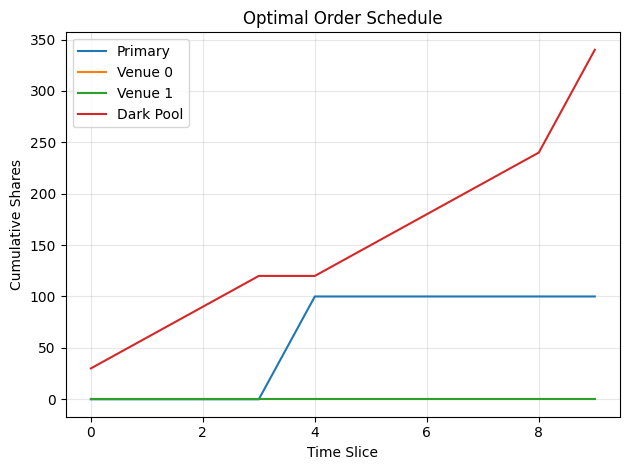

In [46]:

order_schedule = schedule_order(total_size=1000, slice_size=100)
cumulative = order_schedule.cumsum(axis=0)
for v in range(num_venues):
    plt.plot(cumulative[:, v], label=labels[v])
plt.legend()
plt.title("Optimal Order Schedule")
plt.xlabel("Time Slice")
plt.ylabel("Cumulative Shares")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

SUMMARY OUTPUT

In [47]:
print("╔══════════════════════════════════════════════╗")
print("║           ADVANCED ROUTING ANALYTICS         ║")
print("╠══════════════╦══════════╦══════════╦═════════╣")
print("║ Venue        ║ FillProb ║ FillTime ║ Cost    ║")
print("╠══════════════╬══════════╬══════════╬═════════╣")
for v in range(num_venues):
    label = labels[v]
    print(f"║ {label:<12} ║ {venue_fill_probs[v]:6.2%} ║ {venue_fill_times[v]:8.1f} ║ {venue_costs[v]:7.2f} ║")
print("╠══════════════╩══════════╩══════════╩═════════╣")
print(f"║ OPTIMAL: {labels[optimal_venue]} ({venue_costs[optimal_venue]:.2f} bps)                 ║")
print("╚══════════════════════════════════════════════╝")

print("\nOptimal Execution Schedule (1000 shares):")
print(pd.DataFrame(order_schedule, 
                   columns=labels, 
                   index=[f"Slice {i+1}" for i in range(len(order_schedule))]))

╔══════════════════════════════════════════════╗
║           ADVANCED ROUTING ANALYTICS         ║
╠══════════════╦══════════╦══════════╦═════════╣
║ Venue        ║ FillProb ║ FillTime ║ Cost    ║
╠══════════════╬══════════╬══════════╬═════════╣
║ Primary      ║ 44.54% ║     26.0 ║  342.50 ║
║ Venue 0      ║ 18.65% ║    100.0 ║  354.32 ║
║ Venue 1      ║ 33.71% ║     40.0 ║  346.61 ║
║ Dark Pool    ║ 12.80% ║    120.0 ║  357.14 ║
╠══════════════╩══════════╩══════════╩═════════╣
║ OPTIMAL: Primary (342.50 bps)                 ║
╚══════════════════════════════════════════════╝

Optimal Execution Schedule (1000 shares):
          Primary  Venue 0  Venue 1  Dark Pool
Slice 1       0.0      0.0      0.0       30.0
Slice 2       0.0      0.0      0.0       30.0
Slice 3       0.0      0.0      0.0       30.0
Slice 4       0.0      0.0      0.0       30.0
Slice 5     100.0      0.0      0.0        0.0
Slice 6       0.0      0.0      0.0       30.0
Slice 7       0.0      0.0      0.0       30.0
